In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from   tensorflow import keras
from   tensorflow.keras import layers
from   tensorflow.keras.layers.experimental import preprocessing

np.set_printoptions(precision=3, suppress=True)
tf.__version__

'2.4.1'

In [6]:
!ls ../../../../..

R             coursera      geneuralnetic kadenze
README.md     data          images        python
TS            freeCodeCamp  java          scala


In [30]:
# no longer public...., get from Kaggle
#url = ('http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/'
#       'auto-mpg.data')
#col_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
#             'Acceleration', 'Model Year', 'Origin']
#raw_dataset = pd.read_csv(url, 
#                          names=col_names, 
#                          na_values='?', 
#                          comment='\t', 
#                          sep=' ', 
#                          skipinitialspace=True)

DATA = '../../../../../data'
cars =  f'{DATA}/kaggle/auto-mpg.csv'
raw_dataset = pd.read_csv(cars, na_values='?')
dataset = raw_dataset.copy()
print(dataset.shape)
dataset.tail()

(398, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
393,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger
397,31.0,4,119.0,82.0,2720,19.4,82,1,chevy s-10


In [31]:
dataset.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [32]:
dataset = dataset.dropna()
dataset.shape

(392, 9)

In [33]:
dataset.origin = dataset.origin.map({1: 'usa', 2: 'europe', 3: 'japan'})
dataset = pd.get_dummies(
    dataset, columns=['origin'], prefix='', prefix_sep='')
dataset.drop('car name', axis=1, inplace=True)
dataset.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,europe,japan,usa
393,27.0,4,140.0,86.0,2790,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720,19.4,82,0,0,1


In [34]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

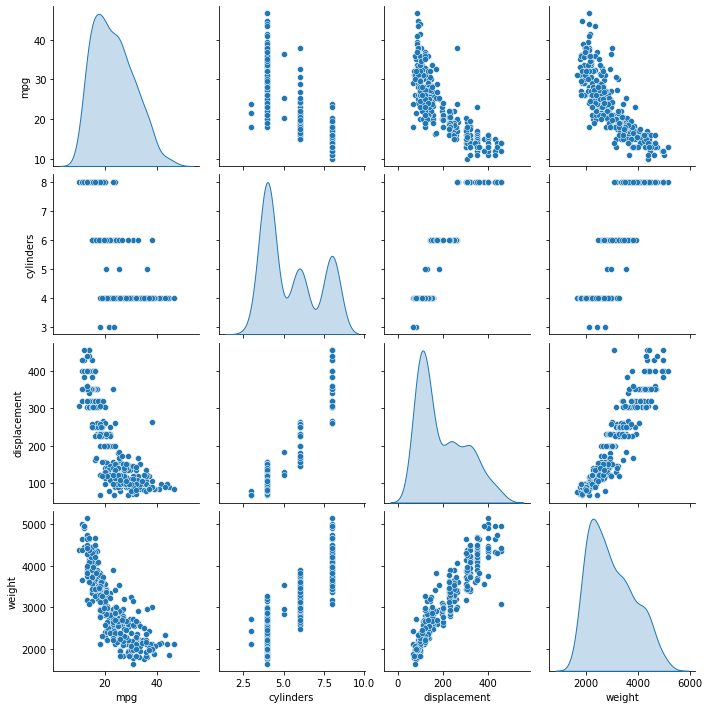

In [35]:
sns.pairplot(train_dataset[['mpg', 'cylinders', 'displacement', 'weight']],
             diag_kind='kde');

In [36]:
train_dataset.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,europe,japan,usa
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.310510,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,0.178344,0.197452,0.624204
std,7.728652,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.383413,0.398712,0.485101
min,10.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,0.000000,0.000000,0.000000
50%,22.000000,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,28.950000,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,0.000000,0.000000,1.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [37]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('mpg')
test_labels = test_features.pop('mpg')

In [38]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
normalizer.mean.numpy() # as above

array([   5.478,  195.318,  104.869, 2990.252,   15.559,   75.898,
          0.178,    0.197,    0.624], dtype=float32)

In [40]:
first = np.array(train_features[:1]) # first record
with np.printoptions(precision=2, suppress=True):
    print('First record:', first)
    print('Normalized:', normalizer(first).numpy())

First record: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]
Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]
